[View in Colaboratory](https://colab.research.google.com/github/aunz/ds/blob/master/Modelling_interaction.ipynb)


Given a non-linear function, such as $y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 + \beta_{12} * x_1 * x_2 + noise$, where we have some intereaction between X1 and X2

What are the options to model $y \sim X$


## Data
We create some random data and group them into 3 sets: train, validation and test

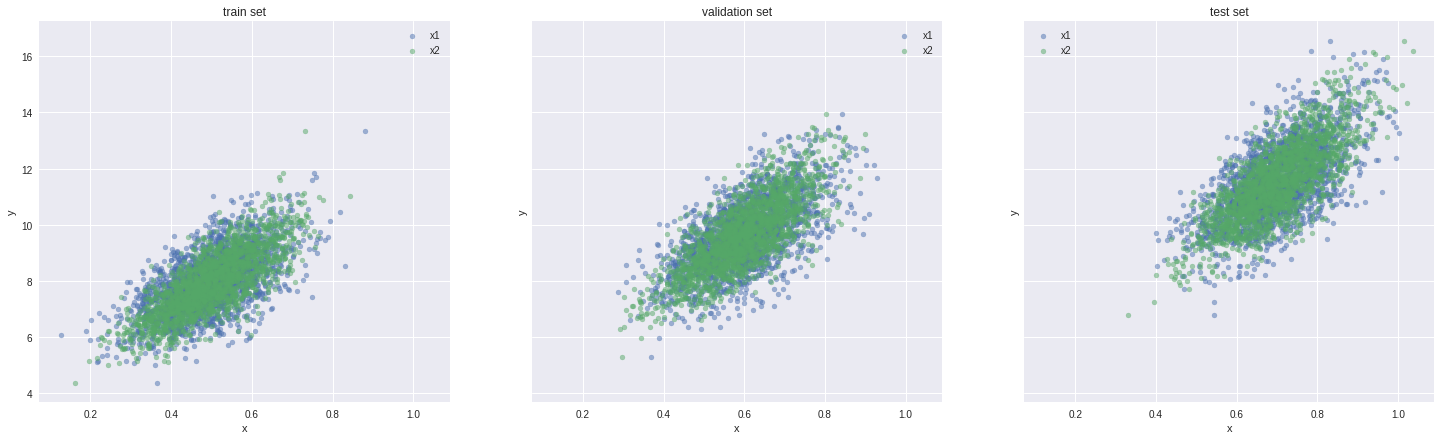

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(0)

def make_y(X, noise=True):
    # given X features, create y target
    x1 = X[:, 0]
    x2 = X[:, 1]
    y = 2 + 3 * x1 + 5 * x2 + 8 * x1 * x2
    if noise: y += 0.1 * np.random.randn(len(X))
    return y

# create a train set with random number normally distributed with mean of 0.5 and standard deviation of 0.1
X_train = 0.1 * np.random.randn(2000, 2) + 0.5
y_train = make_y(X_train)

# similarly for a validation set
X_val = 0.1 * np.random.randn(2000, 2) + 0.6
y_val = make_y(X_val)

# finally for a test set
X_test = 0.1 * np.random.randn(2000, 2) + 0.7
y_test = make_y(X_test)

# plot them
fig, axs = plt.subplots(1, 3, figsize=(25, 7), sharex=True, sharey=True)
for ax, X, y, title in zip(axs, (X_train, X_val, X_test), (y_train, y_val, y_test), ('train set', 'validation set', 'test set')):
    ax.scatter(X[:, 0], y, s=25, alpha=0.5, label='x1')
    ax.scatter(X[:, 1], y, s=25, alpha=0.5, label='x2')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.legend() 

Then define a scoring method. In this case we use root mean squared error.

The algorithms we are going to test:
- Linear regression

In [2]:
from sklearn.metrics import mean_squared_error

# define a scoring method, just root mean square error here
def score(preds, y_true = y_test, title='Test set', plot=True):
    if plot:
        plt.plot([4, 16], [4, 16], c='silver', alpha=0.25)
        plt.scatter(preds, y_true, alpha=0.5, s=10)
        plt.plot([4, 4], [16, 16])
        plt.xlabel('Predicted y')
        plt.ylabel('True y')
        plt.title(title)
    return mean_squared_error(y_true, preds) ** .5


# store scores in a data frame for later summary
scores = pd.DataFrame(columns=['train', 'val', 'test'])


# the best possible rmse, determined by removing the noise
scores.loc['best',:] = [
    score(y_train, make_y(X_train, False), plot=False),
    score(y_val, make_y(X_val, False), plot=False),
    score(y_test, make_y(X_test, False), plot=False)
]

scores

,train,val,test
best,0.0991041,0.100526,0.0993934


## Linear regression

Our first model

We expect that linear regression is not able to capture the interaction using the default settings

intercept: 0.04405896179119306
coef: [6.97941564 8.93196861]


,train,val,test
linear regression,0.124347,0.193235,0.433764


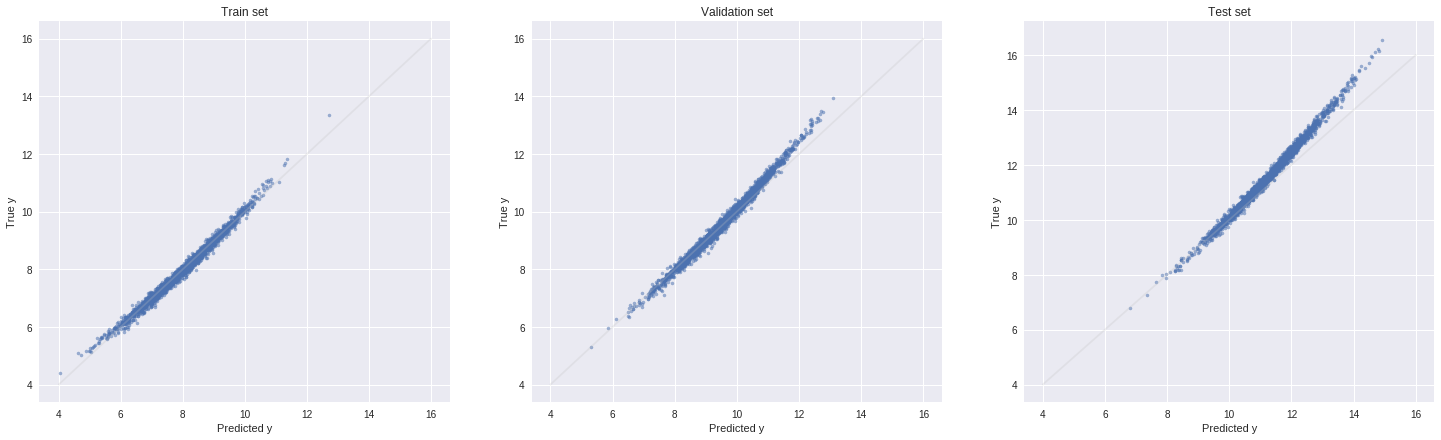

In [3]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
print('intercept:', reg.intercept_)
print('coef:', reg.coef_)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['linear regression',:] = [s1, s2, s3]
scores.iloc[[-1]]

If we manually add another feature which is $x_1 \times x_2$, we get much better results. Our intercept and coefs are closer to our theoretical values.

intercept: 2.0011448426973235
coef: [3.02701319 5.01638516 7.91003007]


,train,val,test
linear regression with interaction,0.0990456,0.100771,0.100748


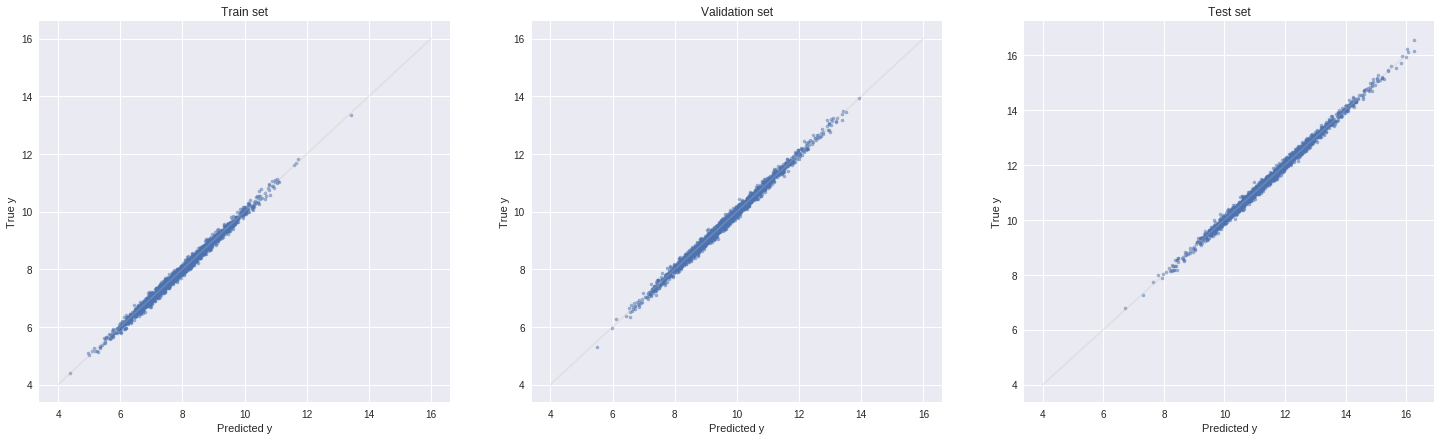

In [4]:
# when we allow interaction

reg = LinearRegression()
reg.fit(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]), y_train) # add another column (feature) composed of x1 * x2
print('intercept:', reg.intercept_)
print('coef:', reg.coef_)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]])), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(np.column_stack([X_val, X_val[:,0] * X_val[:, 1]])), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(np.column_stack([X_test, X_test[:,0] * X_test[:, 1]])), y_test)

scores.loc['linear regression with interaction',:] = [s1, s2, s3]
scores.iloc[[-1]]

### Epsilon support vector Regressor

Out of the default setting, it performs OK with the train set, but poorly on the validation and test set.

It can be tuned by adjusting C and epsilon.

After tuning, both the train and val set are performing much better. The test set has improved a lot, but is still not great.


,train,val,test
svm,0.110778,0.197381,0.515832


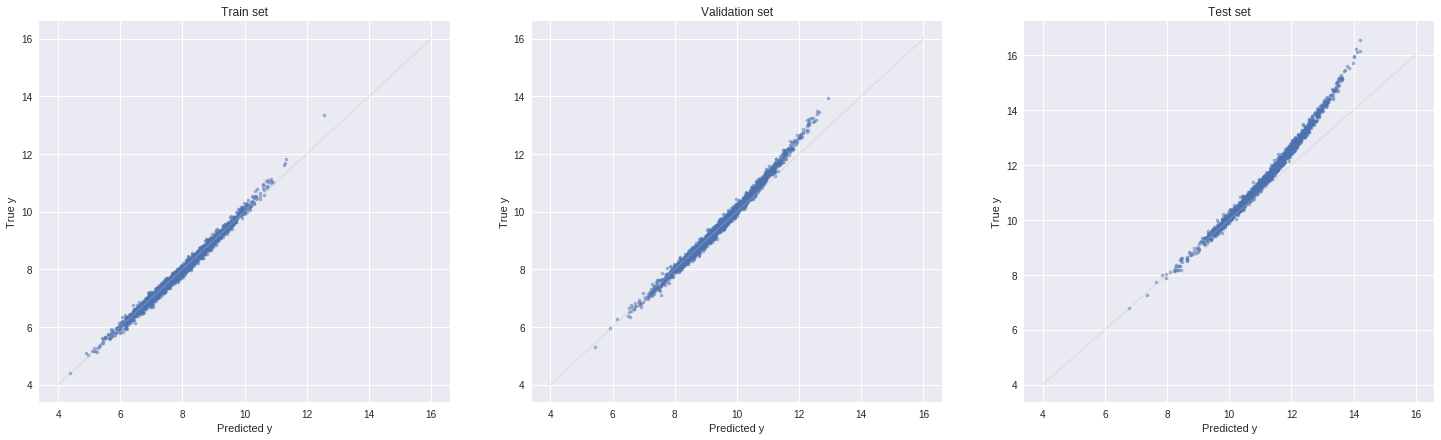

In [5]:
from sklearn.svm import SVR

reg = SVR()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['svm',:] = [s1, s2, s3]
scores.iloc[[-1]]

,train,val,test
svm C50 e0,0.0992692,0.107313,0.175004


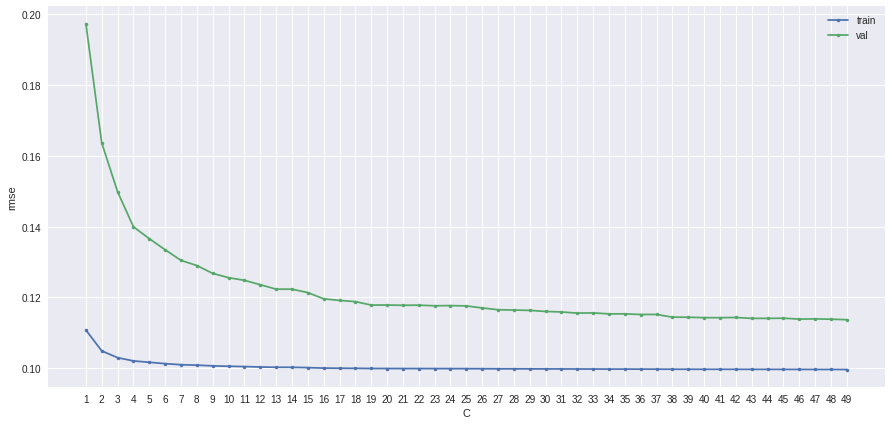

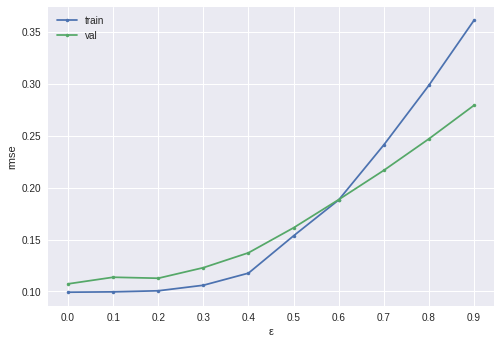

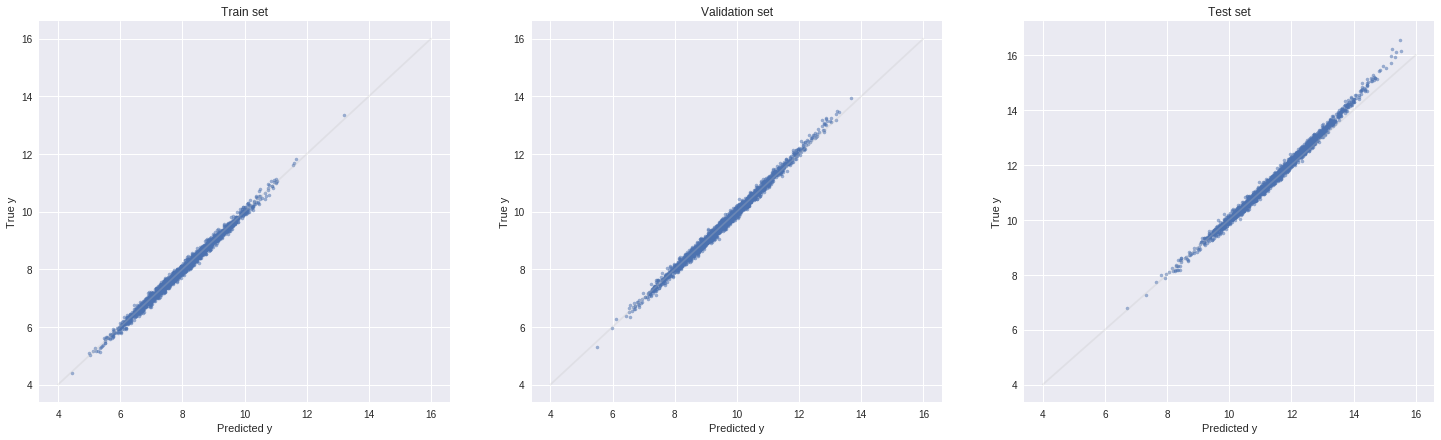

In [8]:
# tuning for SVR

score_train = []
score_val = []
ranges = range(1, 50)

# tune for C
for i in ranges:
    reg = SVR(C=i)
    reg.fit(X_train, y_train)
    score_train.append(score(reg.predict(X_train), y_train, plot=False))
    score_val.append(score(reg.predict(X_val), y_val, plot=False))

plt.figure(figsize=(15, 7))
plt.plot(ranges, score_train, '.-', label='train')
plt.plot(ranges, score_val, '.-', label='val')
plt.xlabel('C')
plt.ylabel('rmse')
plt.xticks(ranges)
plt.legend();

# scores.loc['knn, k = 2',:] = [
#     score(reg.predict(X_train), y_train, 'Train set', plot=False),
#     score(reg.predict(X_val), y_val, 'Train set', plot=False),
#     score(reg.predict(X_test), y_test, 'Train set', plot=False)
# ]
# scores.iloc[[-1]]

score_train = []
score_val = []
ranges = np.arange(0, 1.0, 0.1)

# tune for epsilon
for i in ranges:
    reg = SVR(C=50, epsilon=i)
    reg.fit(X_train, y_train)
    score_train.append(score(reg.predict(X_train), y_train, plot=False))
    score_val.append(score(reg.predict(X_val), y_val, plot=False))

plt.figure()
plt.plot(ranges, score_train, '.-', label='train')
plt.plot(ranges, score_val, '.-', label='val')
plt.xlabel('ε')
plt.ylabel('rmse')
plt.xticks(ranges)
plt.legend();


# the best: C = 50, epsilon = 0

reg = SVR(C=50, epsilon=0)
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['svm C50 e0',:] = [s1, s2, s3]
scores.iloc[[-1]]

### Stochastic gradient descent regressor

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


,train,val,test
SGD regressor,0.694521,1.32383,2.48686


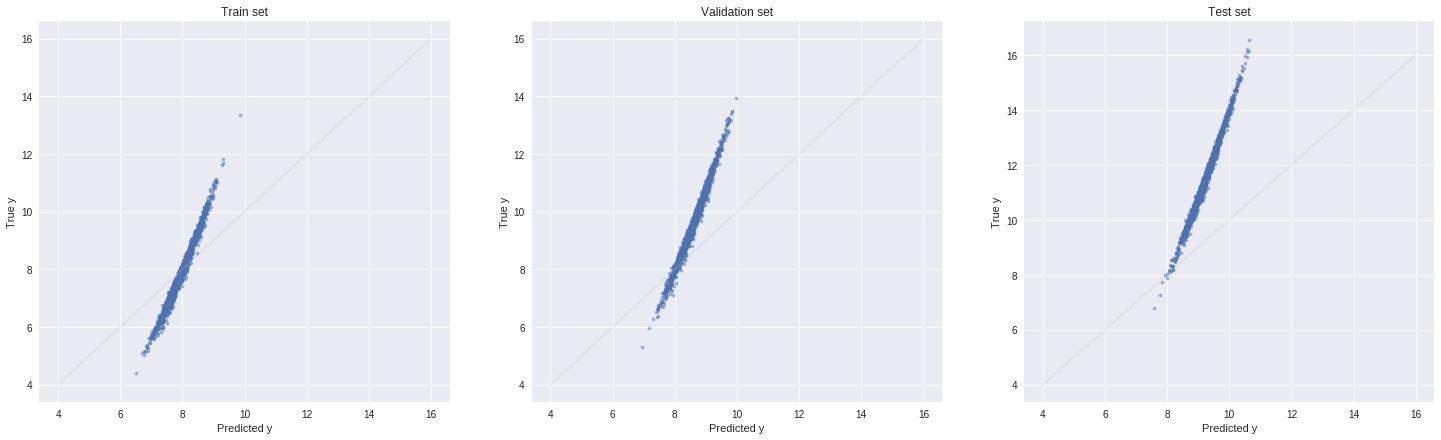

In [9]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['SGD regressor',:] = [s1, s2, s3]
scores.iloc[[-1]]

### K nearest neighbours regressor

It is quite good at the train set. However it performs poorly at the validation and test set.

It is known that KNN regressor cannot extrapolate well for data points beyond the scope of training data range.

,train,val,test
"knn, k = 5",0.106798,0.307,1.0142


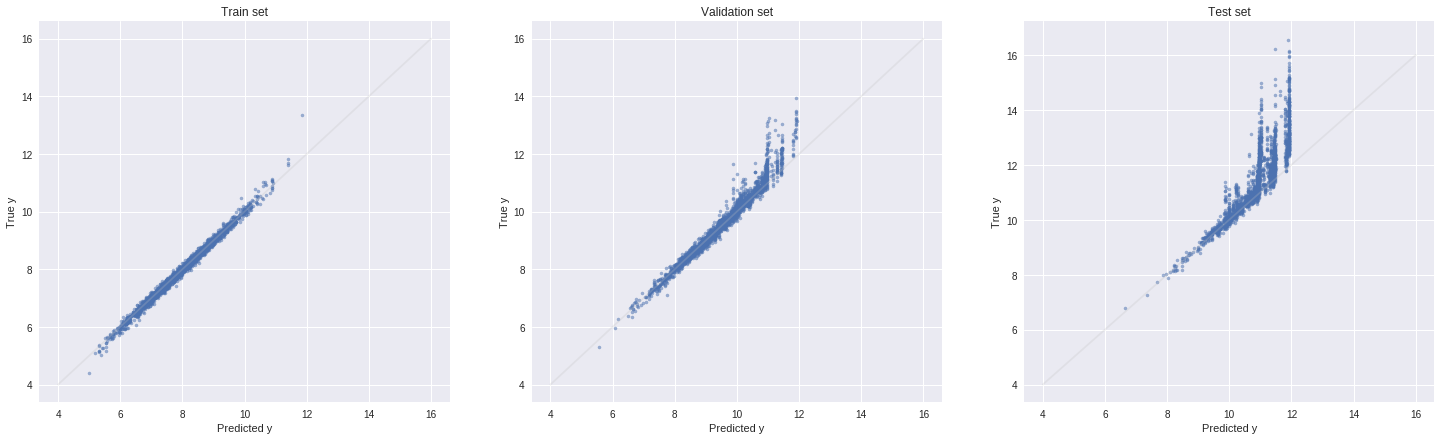

In [10]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['knn, k = 5',:] = [s1, s2, s3]
scores.iloc[[-1]]

,train,val,test
"knn, k = 2",0.139144,0.438521,1.37781


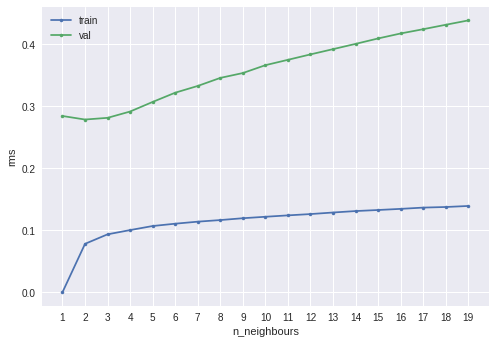

In [11]:
# tuning for k

score_train = []
score_val = []

for i in range(1, 20):
    reg = KNeighborsRegressor(i)
    reg.fit(X_train, y_train)
    score_train.append(score(reg.predict(X_train), y_train, plot=False))
    score_val.append(score(reg.predict(X_val), y_val, plot=False))
    
plt.plot(range(1, 20), score_train, '.-', label='train')
plt.plot(range(1, 20), score_val, '.-', label='val')
plt.xlabel('n_neighbours')
plt.ylabel('rms')
plt.xticks(range(1, 20))
plt.legend();

# k = 2 seems the best
scores.loc['knn, k = 2',:] = [
    score(reg.predict(X_train), y_train, 'Train set', plot=False),
    score(reg.predict(X_val), y_val, 'Train set', plot=False),
    score(reg.predict(X_test), y_test, 'Train set', plot=False)
]
scores.iloc[[-1]]

### Random Forest regressor

It is extremely good at the training set, almost memorising the data (its rmse is smaller than the theoratical best)

However it performs poorly on the validation and test set. Again, similar to KNN, RF does not extrapolate well with data points outsides the training data.

,train,val,test
Random Forest,0.0576681,0.282959,0.82823


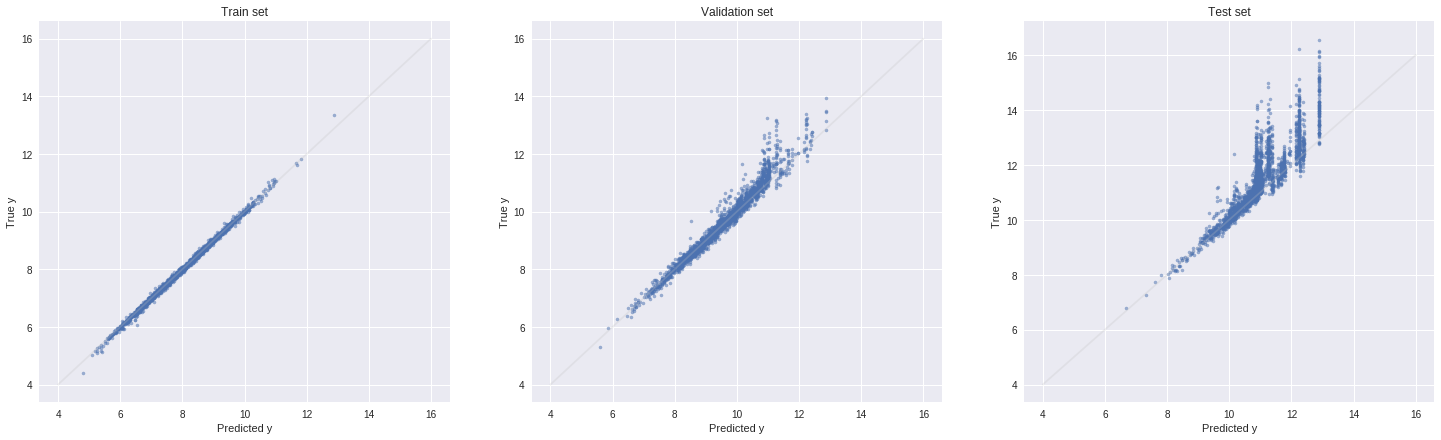

In [12]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['Random Forest',:] = [s1, s2, s3]
scores.iloc[[-1]]

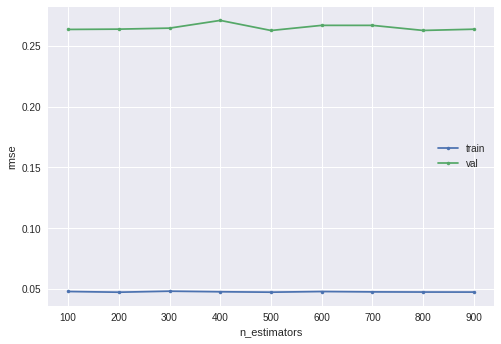

In [13]:
# tuning for random forest

score_train = []
score_val = []
ranges = range(100, 1000, 100)

for i in ranges:
    reg = RandomForestRegressor(n_estimators=i)
    reg.fit(X_train, y_train)
    score_train.append(score(reg.predict(X_train), y_train, plot=False))
    score_val.append(score(reg.predict(X_val), y_val, plot=False))
    
plt.plot(ranges, score_train, '.-', label='train')
plt.plot(ranges, score_val, '.-', label='val')
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend();

# doesn't look like n_estimators make any difference

### Multi-layer Perceptron regressor

,train,val,test
MLPRegressor,0.135877,0.366955,1.05316


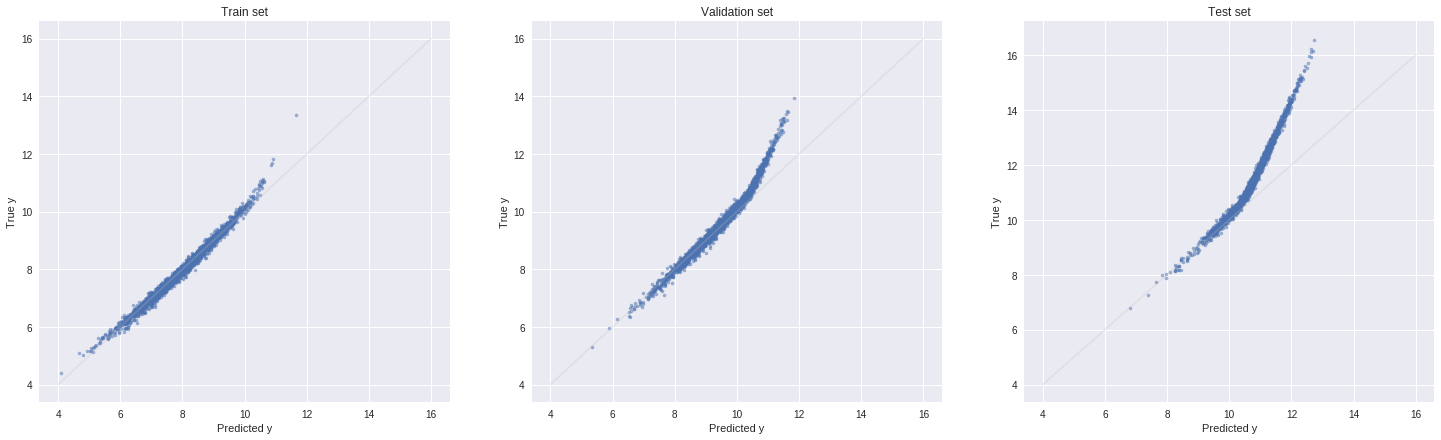

In [14]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor()
reg.fit(X_train, y_train)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(reg.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(reg.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(reg.predict(X_test), y_test)

scores.loc['MLPRegressor',:] = [s1, s2, s3]
scores.iloc[[-1]]

### Neural network

And fianlly, we will try neural network using Keras.

According to the [Universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), an artificial neural network is able to approximate continuous functions on subsets of numbers with just 1 hidden layer containing a finite number of neurons.

Let's see how it models our $y \sim X$.

Firstly, we will just have 1 hidden layer with 1 neuron. This is in essence similar to a simple linear regression.

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Epoch 00356: early stopping


,train,val,test
best,0.0991041,0.100526,0.0993934
linear regression,0.124347,0.193235,0.433764
linear regression with interaction,0.0990456,0.100771,0.100748
NN,0.129944,0.244765,0.543847


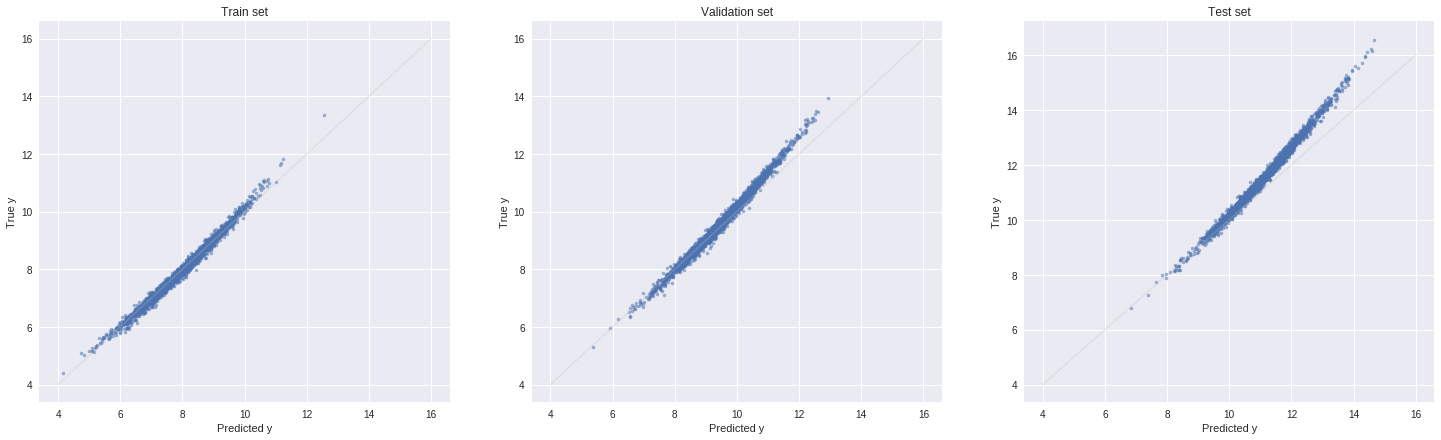

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

earlyStopping = [EarlyStopping(patience=5, verbose=1)]

np.random.seed(0)

model = Sequential()
model.add(Dense(1, input_shape=(2,))) # 1 input layer, 1 output, no activation, so this is essentially similar to linear regression
         
model.summary()
model.compile(loss='mse', optimizer='sgd')
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=earlyStopping, verbose=0)

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
s1 = score(model.predict(X_train), y_train, 'Train set')
plt.subplot(1, 3, 2)
s2 = score(model.predict(X_val), y_val, 'Validation set')
plt.subplot(1, 3, 3)
s3 = score(model.predict(X_test), y_test)

scores.loc['NN',:] = [s1, s2, s3]
scores.loc[['best', 'linear regression', 'linear regression with interaction', 'NN']]

We see that it performs OK on the train set, but poorly on the validation and test set.

We can possibly tune it with various optimizer:
- SGD
- RMSProp
- Adagrad
- Adadelta
- Adam
- Adamax
- Nadam

In [16]:
%%time
from keras import optimizers
from time import time

opts = [
    ('sgd 1', optimizers.SGD()),
    ('sgd 2', optimizers.SGD(lr=0.001)),
    ('sgd 3', optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)),
    ('rmsprop', optimizers.RMSprop()),
    ('adagrad', optimizers.Adagrad()),
    ('adadelta', optimizers.Adadelta()),
    ('adam 1', optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)),
    ('adam 2', optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)),
    ('adamax 1', optimizers.Adamax()),
    ('adamax 2', optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)),
    ('nadam', optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)),
]


for i, opt in opts:
    start = time()
    model = Sequential()
    model.add(Dense(1, input_shape=(2,)))

    model.compile(loss='mse', optimizer=opt)
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_train, y_train), callbacks=earlyStopping, verbose=0)

    s1 = score(model.predict(X_train), y_train, 'Train set', plot=0)
    s2 = score(model.predict(X_val), y_val, 'Validation set', plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    time_taken = time() - start
    
    scores.loc[f'NN 1 {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')

Epoch 00657: early stopping
sgd 1) Train: 0.1244; Validation: 0.1980; Test: 0.4443. Time: 160s
sgd 2) Train: 0.3493; Validation: 0.7136; Test: 1.4091. Time: 246s
sgd 3) Train: 0.3925; Validation: 0.7839; Test: 1.5340. Time: 254s
Epoch 00394: early stopping
rmsprop) Train: 0.1245; Validation: 0.1949; Test: 0.4388. Time: 101s
adagrad) Train: 1.5657; Validation: 2.6191; Test: 3.8916. Time: 253s
Epoch 00341: early stopping
adadelta) Train: 0.1245; Validation: 0.2000; Test: 0.4486. Time: 94s
Epoch 00519: early stopping
adam 1) Train: 0.1244; Validation: 0.1942; Test: 0.4366. Time: 145s
adam 2) Train: 0.5703; Validation: 1.0652; Test: 2.0338. Time: 282s
Epoch 00515: early stopping
adamax 1) Train: 0.1245; Validation: 0.1995; Test: 0.4465. Time: 137s
Epoch 00474: early stopping
adamax 2) Train: 0.1244; Validation: 0.1983; Test: 0.4448. Time: 127s
Epoch 00309: early stopping
nadam) Train: 0.1246; Validation: 0.2029; Test: 0.4540. Time: 93s
CPU times: user 40min 28s, sys: 5min 13s, total: 45min

It looks like rmsprop, adamax performs quite well for a smaller amount of times

Epoch 00112: early stopping
1) Train: 0.1259; Validation: 0.2093; Test: 0.4640. Time: 32s
Epoch 00092: early stopping
2) Train: 0.1246; Validation: 0.1992; Test: 0.4452. Time: 27s
Epoch 00082: early stopping
3) Train: 0.1253; Validation: 0.1874; Test: 0.4229. Time: 25s
Epoch 00072: early stopping
4) Train: 0.1248; Validation: 0.1897; Test: 0.4275. Time: 22s
Epoch 00056: early stopping
5) Train: 0.1307; Validation: 0.2233; Test: 0.4856. Time: 17s
Epoch 00058: early stopping
6) Train: 0.1248; Validation: 0.2020; Test: 0.4510. Time: 18s
Epoch 00057: early stopping
7) Train: 0.1247; Validation: 0.2002; Test: 0.4473. Time: 17s
Epoch 00044: early stopping
8) Train: 0.1312; Validation: 0.1790; Test: 0.4022. Time: 14s
Epoch 00047: early stopping
16) Train: 0.1256; Validation: 0.2045; Test: 0.4541. Time: 14s
Epoch 00038: early stopping
32) Train: 0.1252; Validation: 0.1867; Test: 0.4209. Time: 12s
Epoch 00021: early stopping
64) Train: 0.1314; Validation: 0.1784; Test: 0.4005. Time: 7s
Epoch 00

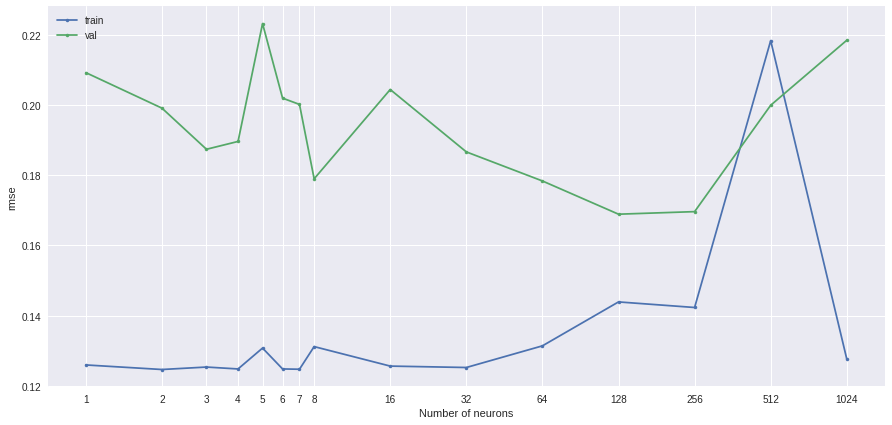

In [17]:
%%time
# tuning for number of neurons in the first hidden layer
# from tqdm import tqdm # for progress bar

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(2,)))
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_train, y_train), callbacks=earlyStopping, verbose=0)
    
    s1 = score(model.predict(X_train), y_train, plot=0)
    s2 = score(model.predict(X_val), y_val, plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train', )
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();

It looks like there is no improvement with increasing the number of neurons 😔.

We can do what we did for linear regression with interaction term. Concretely, we add another feature which is a result of x1 * x2.

Epoch 00103: early stopping
1) Train: 0.1025; Validation: 0.1185; Test: 0.1860. Time: 31s
Epoch 00066: early stopping
2) Train: 0.1012; Validation: 0.1033; Test: 0.1169. Time: 21s
Epoch 00052: early stopping
3) Train: 0.0998; Validation: 0.1015; Test: 0.1026. Time: 17s
Epoch 00043: early stopping
4) Train: 0.1082; Validation: 0.1143; Test: 0.1192. Time: 14s
Epoch 00039: early stopping
5) Train: 0.1099; Validation: 0.1122; Test: 0.1107. Time: 13s
Epoch 00036: early stopping
6) Train: 0.1044; Validation: 0.1160; Test: 0.1473. Time: 12s
Epoch 00032: early stopping
7) Train: 0.1063; Validation: 0.1199; Test: 0.1554. Time: 11s
Epoch 00031: early stopping
8) Train: 0.1090; Validation: 0.1342; Test: 0.2104. Time: 11s
Epoch 00022: early stopping
16) Train: 0.1031; Validation: 0.1210; Test: 0.1877. Time: 8s
Epoch 00018: early stopping
32) Train: 0.1103; Validation: 0.1250; Test: 0.1587. Time: 7s
Epoch 00022: early stopping
64) Train: 0.1010; Validation: 0.1045; Test: 0.1235. Time: 8s
Epoch 0001

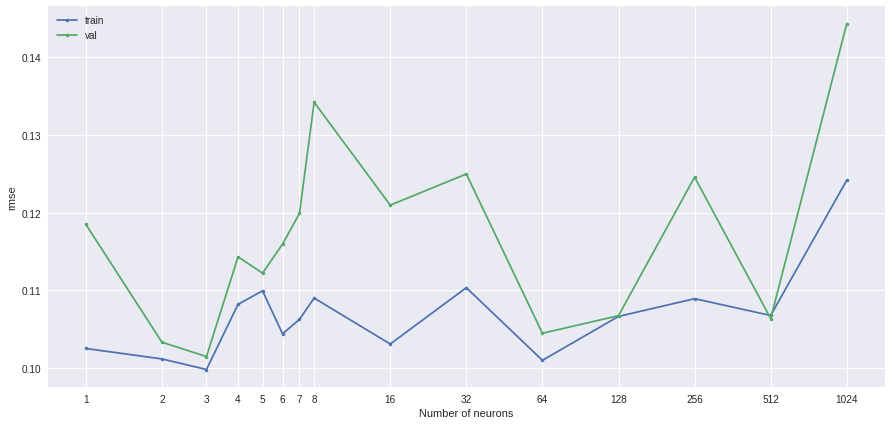

In [18]:
%%time

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(3,))) # now 3 features
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(
        np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]), # add the additional feature
        y_train,
        validation_data=(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]), y_train),
        epochs=1000, callbacks=earlyStopping, verbose=0
    )
    
    s1 = score(model.predict(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]])), y_train, 'Train set', plot=0)
    s2 = score(model.predict(np.column_stack([X_val, X_val[:,0] * X_val[:, 1]])), y_val, 'Validation set', plot=0)
    s3 = score(model.predict(np.column_stack([X_test, X_test[:,0] * X_test[:, 1]])), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN 3 features {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train', )
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();

The rmse for train set has improved a lot to below 0.10 from initial ~0.12

However, the validation and test set are still not that great, particularly compared with the results obtained from linear regression with interaction term.



Epoch 00066: early stopping
1) Train: 0.1042; Validation: 0.1069; Test: 0.1378. Time: 23s
Epoch 00044: early stopping
2) Train: 0.1032; Validation: 0.1140; Test: 0.1445. Time: 16s
Epoch 00046: early stopping
3) Train: 0.1085; Validation: 0.1371; Test: 0.2614. Time: 17s
Epoch 00048: early stopping
4) Train: 0.1005; Validation: 0.1086; Test: 0.1446. Time: 18s
Epoch 00044: early stopping
5) Train: 0.1027; Validation: 0.1040; Test: 0.1019. Time: 17s
Epoch 00033: early stopping
6) Train: 0.1001; Validation: 0.1051; Test: 0.1276. Time: 13s
Epoch 00035: early stopping
7) Train: 0.1012; Validation: 0.1099; Test: 0.1382. Time: 14s
Epoch 00036: early stopping
8) Train: 0.1055; Validation: 0.1161; Test: 0.1418. Time: 15s
Epoch 00028: early stopping
16) Train: 0.0997; Validation: 0.1048; Test: 0.1244. Time: 12s
Epoch 00021: early stopping
32) Train: 0.1066; Validation: 0.1212; Test: 0.1609. Time: 10s
Epoch 00032: early stopping
64) Train: 0.0999; Validation: 0.1019; Test: 0.1077. Time: 13s
Epoch 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


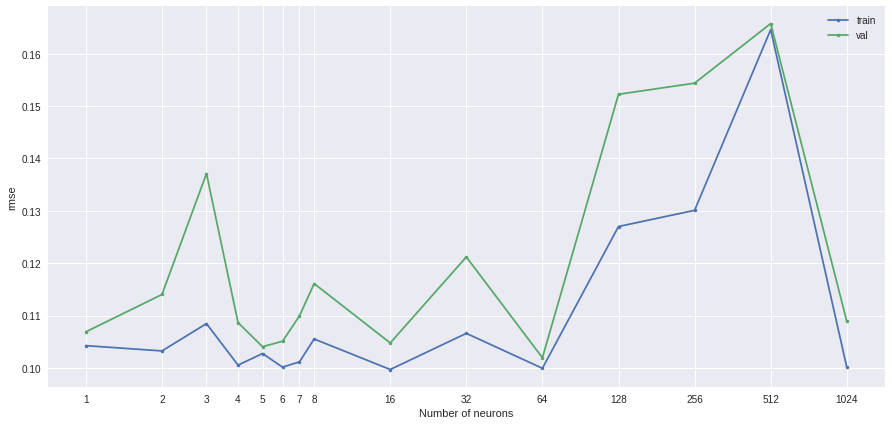

In [22]:
%%time
# we repeat again now in the model.fit, in validation_data, we use X_val and y_val

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(3,)))
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(
        np.column_stack([X_train, X_train[:,0] * X_train[:, 1]]),
        y_train,
        validation_data=(np.column_stack([X_val, X_val[:,0] * X_val[:, 1]]), y_val), # using X_val, and y_val
        epochs=1000, callbacks=earlyStopping, verbose=0
    )
    
    s1 = score(model.predict(np.column_stack([X_train, X_train[:,0] * X_train[:, 1]])), y_train, 'Train set', plot=0)
    s2 = score(model.predict(np.column_stack([X_val, X_val[:,0] * X_val[:, 1]])), y_val, 'Validation set', plot=0)
    s3 = score(model.predict(np.column_stack([X_test, X_test[:,0] * X_test[:, 1]])), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN 3 features w val {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train', )
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();

print(scores.loc[['best', 'linear regression with intereaction', 'NN 3 features w val 1']])

Using the validation set when fitting, we can see that even with just 1 neurons, we have achieved similar scores to the theoretically best rmse, and the linear regression with interaction term.

Yay! 🎉

However, this is not what neural network should be told. It should be able to approximate the y ~ X function without feature engineering.

We can try different activation functions

Epoch 00320: early stopping
1) Train: 0.1244; Validation: 0.2633; Test: 0.8056. Time: 108s
Epoch 00295: early stopping
2) Train: 0.1217; Validation: 0.2311; Test: 0.6581. Time: 99s
Epoch 00260: early stopping
3) Train: 0.1206; Validation: 0.2198; Test: 0.6230. Time: 116s
Epoch 00178: early stopping
4) Train: 0.1279; Validation: 0.2674; Test: 0.7363. Time: 95s
Epoch 00219: early stopping
5) Train: 0.1217; Validation: 0.2043; Test: 0.5690. Time: 120s
Epoch 00188: early stopping
6) Train: 0.1229; Validation: 0.2146; Test: 0.5938. Time: 115s
Epoch 00216: early stopping
7) Train: 0.1368; Validation: 0.2917; Test: 0.7665. Time: 75s
Epoch 00182: early stopping
8) Train: 0.1230; Validation: 0.2046; Test: 0.5559. Time: 117s
Epoch 00102: early stopping
16) Train: 0.1476; Validation: 0.2869; Test: 0.7692. Time: 64s
Epoch 00080: early stopping
32) Train: 0.1442; Validation: 0.3090; Test: 0.7901. Time: 30s
Epoch 00060: early stopping
64) Train: 0.1536; Validation: 0.2680; Test: 0.7005. Time: 23s
Ep

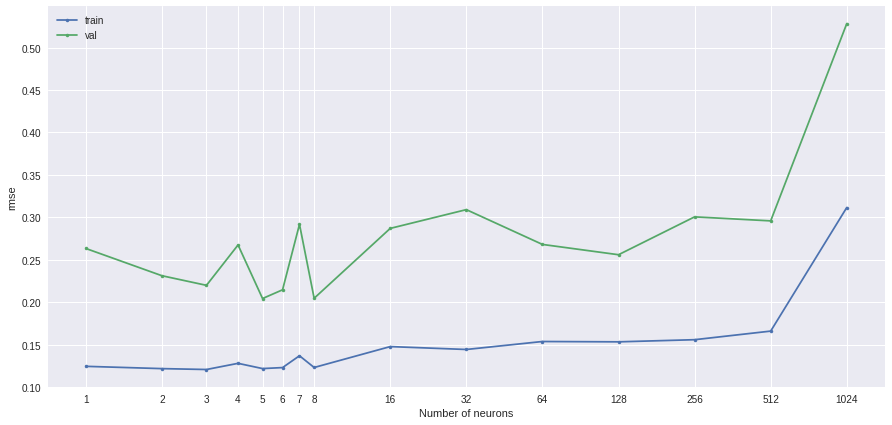

In [24]:
%%time

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(2,), activation='sigmoid')) # add activation 
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_train, y_train), callbacks=earlyStopping, verbose=0)
    
    s1 = score(model.predict(X_train), y_train, plot=0)
    s2 = score(model.predict(X_val), y_val, plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN sigmoid {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train', )
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();

Epoch 00089: early stopping
1) Train: 0.1247; Validation: 0.1900; Test: 0.4281. Time: 12s
Epoch 00038: early stopping
2) Train: 0.1247; Validation: 0.1897; Test: 0.4273. Time: 12s
Epoch 00041: early stopping
3) Train: 0.1345; Validation: 0.1733; Test: 0.3842. Time: 12s
Epoch 00033: early stopping
4) Train: 0.1253; Validation: 0.2037; Test: 0.4530. Time: 12s
Epoch 00026: early stopping
5) Train: 0.1314; Validation: 0.1774; Test: 0.3977. Time: 12s
Epoch 00039: early stopping
6) Train: 0.1308; Validation: 0.1756; Test: 0.3927. Time: 12s
Epoch 00030: early stopping
7) Train: 0.1921; Validation: 0.1829; Test: 0.2950. Time: 12s
Epoch 00032: early stopping
8) Train: 0.1746; Validation: 0.1743; Test: 0.3168. Time: 12s
                                         train       val       test
best                                 0.0991041  0.100526  0.0993934
linear regression with intereaction        NaN       NaN        NaN
NN 3 features w val 1                 0.104245  0.106882   0.137847
CPU time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


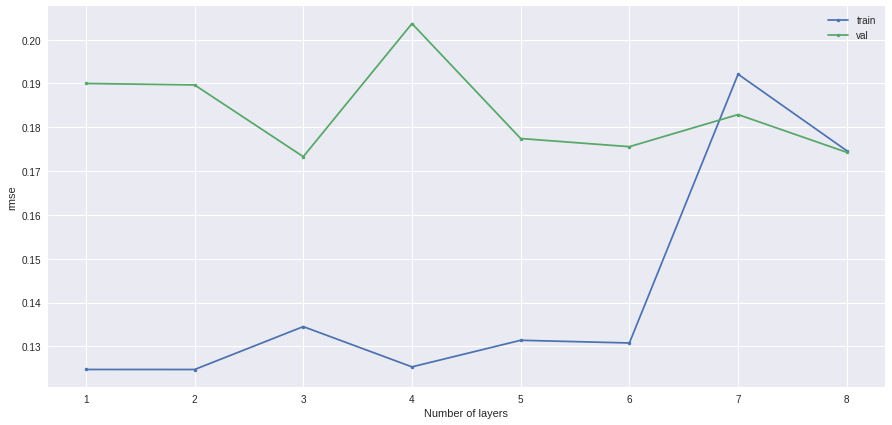

In [33]:
%%time
# tune for numbers of hidden layer

score_train = []
score_val = []
ranges = range(1, 9)

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(3, input_shape=(2,)))
    for j in range(1, i): model.add(Dense(3))
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=earlyStopping, verbose=0)
    
    s1 = score(model.predict(X_train), y_train, plot=0)
    s2 = score(model.predict(X_val), y_val, plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN layers {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
    
plt.figure(figsize=(15, 7))
plt.plot((ranges), score_train, '.-', label='train')
plt.plot((ranges), score_val, '.-', label='val')
plt.xlabel('Number of layers')
plt.ylabel('rmse')
plt.xticks(ranges, ranges)
plt.legend();

print(scores.loc[['best', 'linear regression with intereaction', 'NN 3 features w val 1']])

Adding more hidden layers did not seem to help at all.


We can try different activation functions, such as relu, tanh

In [0]:
# model.get_weights()

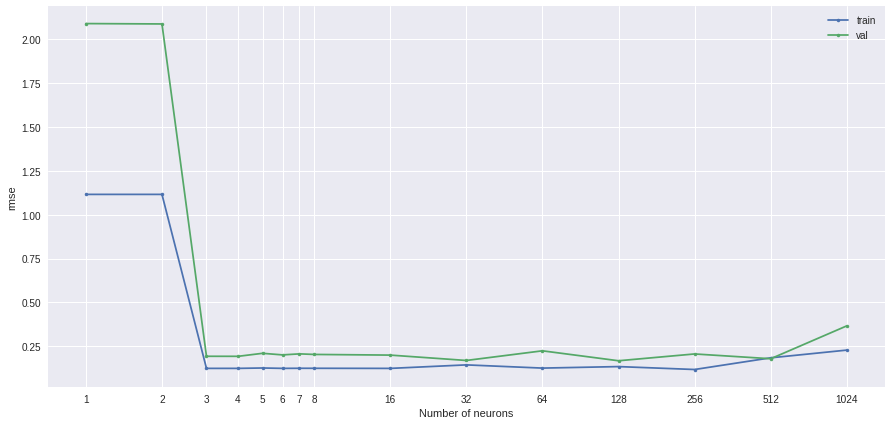

In [35]:
%%time
# try with activation: relu

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(2,), activation='relu')) # use relu
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_train, y_train), callbacks=earlyStopping, verbose=0)
    
    s1 = score(model.predict(X_train), y_train, plot=0)
    s2 = score(model.predict(X_val), y_val, plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN relu {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train')
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();

Obviously, with 1 or 2 neurons, 'relu' is bad!

What about sigmoidal activation

Epoch 00419: early stopping
1) Train: 0.1247; Validation: 0.2314; Test: 0.7402. Time: 165s
Epoch 00258: early stopping
2) Train: 0.1242; Validation: 0.2421; Test: 0.7138. Time: 103s
Epoch 00234: early stopping
3) Train: 0.1230; Validation: 0.2386; Test: 0.6714. Time: 95s
Epoch 00198: early stopping
4) Train: 0.1253; Validation: 0.2476; Test: 0.6865. Time: 82s
Epoch 00169: early stopping
5) Train: 0.1260; Validation: 0.2486; Test: 0.6789. Time: 71s
Epoch 00179: early stopping
6) Train: 0.1234; Validation: 0.2182; Test: 0.6024. Time: 75s
Epoch 00172: early stopping
7) Train: 0.1244; Validation: 0.2324; Test: 0.6246. Time: 73s
Epoch 00148: early stopping
8) Train: 0.1262; Validation: 0.2421; Test: 0.6437. Time: 64s
Epoch 00133: early stopping
16) Train: 0.1226; Validation: 0.2168; Test: 0.5654. Time: 57s
Epoch 00078: early stopping
32) Train: 0.1457; Validation: 0.3159; Test: 0.7981. Time: 38s
Epoch 00074: early stopping
64) Train: 0.1524; Validation: 0.2606; Test: 0.6814. Time: 36s
Epoch

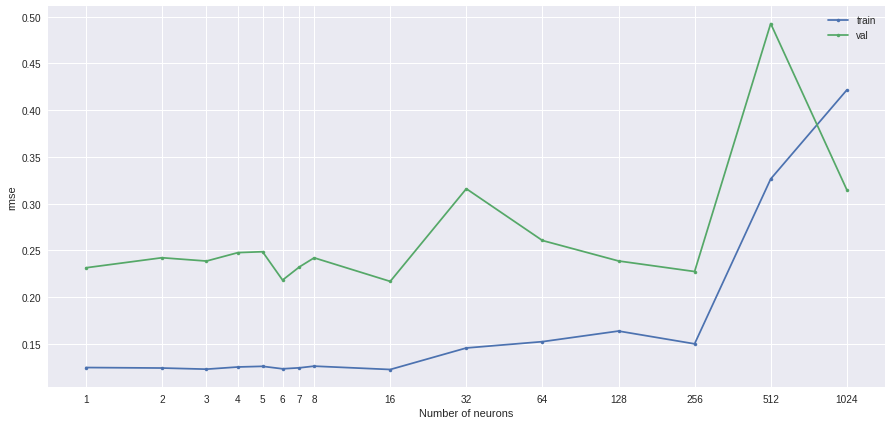

In [36]:
%%time
# try with activation: sigmoid

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(2,), activation='sigmoid'))
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_train, y_train), callbacks=earlyStopping, verbose=0)
    
    s1 = score(model.predict(X_train), y_train, plot=0)
    s2 = score(model.predict(X_val), y_val, plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN sigmoid {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train')
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();

Epoch 00306: early stopping
1) Train: 0.1541; Validation: 0.3613; Test: 0.9904. Time: 252s
Epoch 00324: early stopping
2) Train: 0.1500; Validation: 0.3657; Test: 0.9543. Time: 179s
Epoch 00185: early stopping
3) Train: 0.1587; Validation: 0.3922; Test: 1.0150. Time: 79s
Epoch 00213: early stopping
4) Train: 0.1522; Validation: 0.3409; Test: 0.9059. Time: 99s
Epoch 00123: early stopping
5) Train: 0.1698; Validation: 0.3898; Test: 1.0283. Time: 56s
Epoch 00152: early stopping
6) Train: 0.1585; Validation: 0.3869; Test: 0.9870. Time: 80s
Epoch 00128: early stopping
7) Train: 0.1614; Validation: 0.3925; Test: 0.9975. Time: 58s
Epoch 00071: early stopping
8) Train: 0.1712; Validation: 0.4172; Test: 1.0664. Time: 36s
Epoch 00044: early stopping
16) Train: 0.1617; Validation: 0.3365; Test: 0.8869. Time: 26s
Epoch 00026: early stopping
32) Train: 0.1445; Validation: 0.2792; Test: 0.7241. Time: 19s
Epoch 00028: early stopping
64) Train: 0.1346; Validation: 0.2518; Test: 0.6274. Time: 20s
Epoch

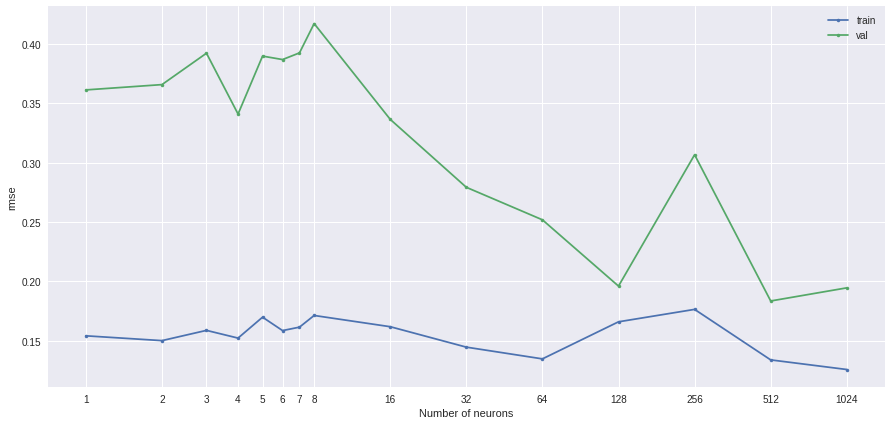

In [38]:
%%time
# try with activation: tanh

score_train = []
score_val = []
ranges = list(range(1, 8)) + [2 ** i for i in range(3, 11)]

for i in ranges:
    start = time()
    model = Sequential()
    model.add(Dense(i, input_shape=(2,), activation='tanh'))
    model.add(Dense(1))
         
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=1000, validation_data=(X_train, y_train), callbacks=earlyStopping, verbose=0)
    
    s1 = score(model.predict(X_train), y_train, plot=0)
    s2 = score(model.predict(X_val), y_val, plot=0)
    s3 = score(model.predict(X_test), y_test, plot=0)
    time_taken = time() - start
    
    score_train.append(s1)
    score_val.append(s2)
    
    scores.loc[f'NN tanh {i}',:] = [s1, s2, s3]
    
    print(f'''{i}) Train: {s1:.4f}; Validation: {s2:.4f}; Test: {s3:.4f}. Time: {time_taken:.0f}s''')
    
plt.figure(figsize=(15, 7))
plt.plot(np.log2(ranges), score_train, '.-', label='train')
plt.plot(np.log2(ranges), score_val, '.-', label='val')
plt.xlabel('Number of neurons')
plt.ylabel('rmse')
plt.xticks(np.log2(ranges), ranges)
plt.legend();